In [2]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

In [3]:

valid_classes = [0,85, 170]
class_names = ["Background","Pupil","Iris"]


class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{0: 0, 85: 1, 170: 2}

In [4]:
colors = [ [  0,   0,   0],[0,255,0],[0,0,255]]
label_colours = dict(zip(range(n_classes), colors))

label_colours


{0: [0, 0, 0], 1: [0, 255, 0], 2: [0, 0, 255]}

In [5]:
def encode_segmap(mask):
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

In [6]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
train_transform=A.Compose(
[
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

val_transform=A.Compose(
[
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

In [8]:
from torch.utils.data import Dataset
from PIL import  Image


In [20]:
class Iris(Dataset):
    def __init__(self,x,y,transform=None):
        self.images_dir = x
        self.masks_dir = y
        self.transform = transform
    def __getitem__(self,index):
        image = Image.open(self.images_dir[index]).convert("RGB")
        mask = Image.open(self.masks_dir[index])
        
        if self.transform is not None:
            transformed =  self.transform(image = np.array(image),mask = np.array(mask))
        return transformed["image"],transformed["mask"]
    
    def __len__(self):
        return len(self.images_dir)

In [8]:
from glob import glob
train_images = "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/MICHE_MULTICLASS/Dataset/train_img/"
train_masks  = "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/MICHE_MULTICLASS/Dataset/train_masks/"


val_images = "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/MICHE_MULTICLASS/Dataset/val_img"

val_masks =  "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/MICHE_MULTICLASS/Dataset/val_masks/" 


train_x = sorted(
        glob(f"{train_images}/*"))
train_y = sorted(
        glob(f"{train_masks}/*"))
valid_x = sorted(
        glob(f"{val_images}/*"))
valid_y = sorted(
        glob(f"{val_masks }/*"))

In [53]:
train_dataset = Iris(train_x,train_y,transform=train_transform)
image,seg = train_dataset[20]

print(image.shape)
print(seg.shape)

torch.Size([3, 512, 512])
torch.Size([512, 512])


In [55]:
print(torch.max(image))
print(torch.min(image))
print(torch.mean(image))

tensor(2.6400)
tensor(-2.1008)
tensor(-0.0897)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


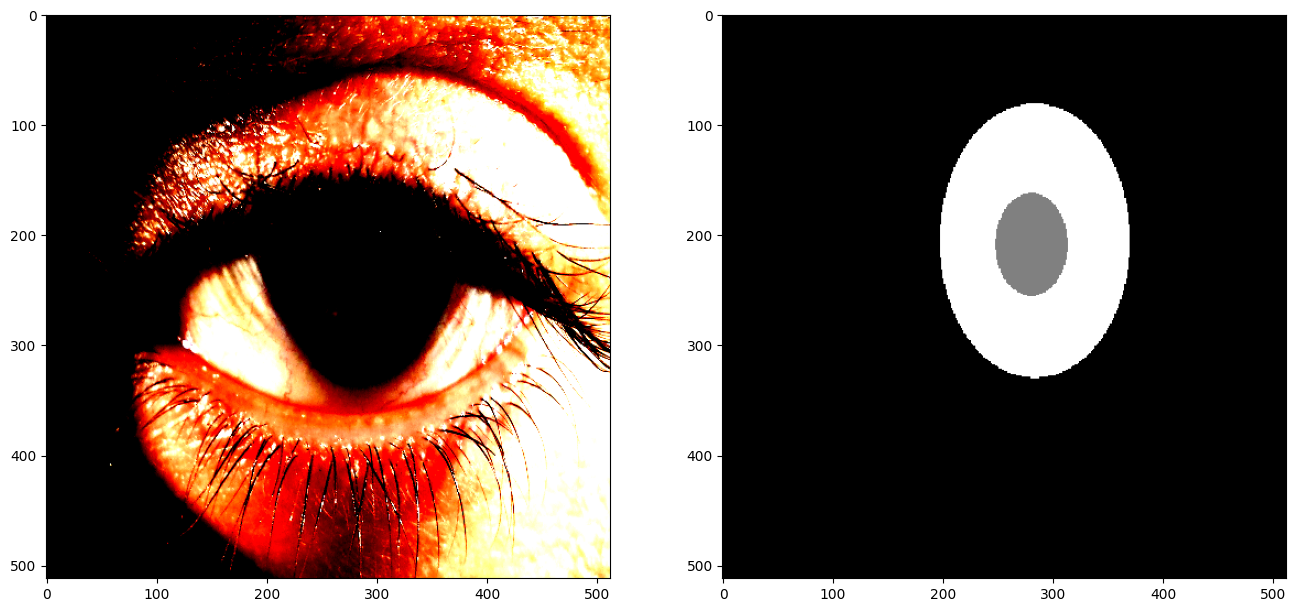

In [23]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(image.permute(1,2,0))
ax[1].imshow(seg,cmap="gray")

In [24]:
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([  0,  85, 170], dtype=torch.uint8)
3


In [25]:
res = encode_segmap(seg.clone())

print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

torch.Size([512, 512])
tensor([0, 1, 2], dtype=torch.uint8)
3


In [26]:
res_1 = decode_segmap(res.clone())


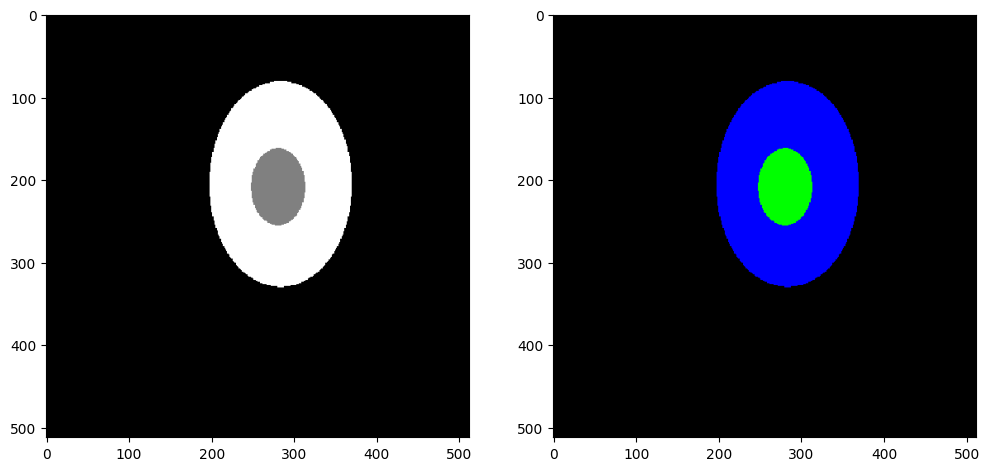

In [27]:
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res_1)

In [28]:
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
import segmentation_models_pytorch as smp
from pytorch_lightning import seed_everything,LightningModule,Trainer
import multiprocessing
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
import torch

In [29]:
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel, self).__init__()
        self.layer = smp.Unet(encoder_name="resnet34",
                              encoder_weights="imagenet",
                              in_channels = 3,
                              classes=n_classes)
        
        self.lr = 1e-3
        self.batch_size = 4
        self.numworker = multiprocessing.cpu_count()//4
        self.criterion = smp.losses.DiceLoss(mode = "multiclass")
        self.metrics = MulticlassJaccardIndex(num_classes=n_classes)
        
        
        self.train_cls = Iris(train_x,train_y,transform=train_transform)
        self.val_cls = Iris(valid_x,valid_y,transform=val_transform)
        
    def process(self,image,segment):
        out = self.layer(image)
        segment = encode_segmap(segment)
        loss = self.criterion(out,segment.long())
        iou = self.metrics(out,segment)
        return loss,iou
    
    def forward(self,x):
        return self.layer(x)
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(),lr=self.lr)
        return opt
    
    def train_dataloader(self):
        return DataLoader(self.train_cls,batch_size=self
                          .batch_size,shuffle=False,num_workers=self.numworker,
                          pin_memory=True)
    def training_step(self,batch,batch_idx):
        image,segment = batch
        loss,iou = self.process(image,segment)
        self.log('train_loss', loss,on_step=False, on_epoch=True,prog_bar=True)
        self.log('train_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
        return loss
        
    def val_dataloader(self):
        return DataLoader(self.val_cls, batch_size=self.batch_size, 
                        shuffle=False,num_workers=self.numworker,pin_memory=True)
        
    def validation_step(self,batch,batch_idx):
        image,segment=batch
        loss,iou=self.process(image,segment)
        self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
        self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
        return loss
        

In [30]:
model = OurModel()
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='checkpoints',
                                        filename='file',save_last=True)

In [66]:
 inputs, classes = next(iter(model.train_dataloader()))   

In [70]:
inputs[1]

tensor([[[ 1.6838,  1.6667,  1.7352,  ..., -0.8164, -0.7650, -0.7993],
         [ 1.6838,  1.7180,  1.7009,  ..., -0.7650, -0.7650, -0.7822],
         [ 1.6838,  1.6667,  1.6838,  ..., -0.7650, -0.7308, -0.8335],
         ...,
         [ 1.0673,  1.0673,  1.0159,  ...,  1.7694,  1.7865,  1.7865],
         [ 1.0502,  1.0159,  1.0331,  ...,  1.7694,  1.8208,  1.8037],
         [ 0.9988,  0.9474,  0.9988,  ...,  1.7694,  1.8379,  1.8379]],

        [[ 1.8508,  1.8333,  1.9034,  ..., -0.9328, -0.9153, -0.9503],
         [ 1.8508,  1.8859,  1.8683,  ..., -0.8627, -0.8803, -0.9328],
         [ 1.8508,  1.8333,  1.8508,  ..., -0.8452, -0.8277, -0.9853],
         ...,
         [ 0.9580,  0.9580,  0.9055,  ...,  1.8158,  1.8333,  1.8333],
         [ 0.9405,  0.9055,  0.9230,  ...,  1.8158,  1.8683,  1.8333],
         [ 0.9055,  0.8529,  0.9230,  ...,  1.8333,  1.9034,  1.9034]],

        [[ 2.0300,  2.0125,  2.0823,  ..., -0.6541, -0.5844, -0.6715],
         [ 2.0300,  2.0648,  2.0474,  ..., -0

In [31]:
trainer = Trainer(max_epochs=200, auto_lr_find=False, auto_scale_batch_size=False,
                  gpus=-1,precision=16,
                  callbacks=[checkpoint_callback],
                 )

/home/nipun/mambaforge/envs/LuminEye/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
train_cls = Iris(train_x,train_y,transform=train_transform)
val_cls = Iris(valid_x,valid_y,transform=val_transform)

In [39]:
img,seg = train_cls[0]
img = img[None,:,:,:]
seg = seg[None,:,:]
print(img.shape)
print(seg.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 512, 512])


In [72]:
out_1 = layer(inputs)

In [74]:
out_1.shape


torch.Size([4, 3, 512, 512])

In [43]:
layer = smp.Unet(encoder_name="resnet34",
                              encoder_weights="imagenet",
                              in_channels = 3,
                              classes=n_classes
                              )

criterion = smp.losses.DiceLoss(mode = "multiclass")
out = layer(img)

print(out.shape)


segment = encode_segmap(seg)
print(segment.shape)

segment = segment.long()

print(out.dtype)
print(segment.dtype)
loss = loss(out,segment.long)


torch.Size([1, 3, 512, 512])
torch.Size([1, 512, 512])
torch.float32
torch.int64


AttributeError: 'builtin_function_or_method' object has no attribute 'size'

In [52]:
out

tensor([[[[-0.2812,  0.4073,  0.8969,  ..., -0.3979, -0.1333,  0.0429],
          [-0.7479,  0.6886,  0.5231,  ...,  0.0494,  0.3373,  0.8560],
          [-0.4161,  0.7556,  0.4209,  ...,  1.5608,  2.3648,  1.9534],
          ...,
          [ 1.0682,  0.5773,  1.0705,  ...,  0.8641,  1.8640,  2.0367],
          [ 0.3785,  0.1823,  1.5570,  ...,  1.1852,  1.7301,  2.5236],
          [ 0.2580,  0.6262,  0.6993,  ...,  1.1357,  1.9478,  2.1034]],

         [[-0.4482, -0.7087, -1.3544,  ..., -1.5745, -1.2412, -0.8438],
          [-0.7974, -2.2263, -1.6806,  ..., -3.3599, -2.5088, -1.2469],
          [ 0.2005, -1.9832, -1.9886,  ..., -4.3531, -3.3889, -1.8137],
          ...,
          [-1.0323, -3.4841, -3.0647,  ..., -2.9339, -2.1379, -1.4927],
          [-0.8110, -2.6256, -2.8763,  ..., -3.1633, -1.9969, -1.3755],
          [-0.1853, -1.9246, -1.5675,  ..., -4.0140, -2.7928, -0.9379]],

         [[-0.0809,  2.2041,  1.8344,  ...,  0.8166,  1.0659, -0.7146],
          [ 0.3872,  1.5898,  

In [101]:
segment.size(0)

1

In [102]:
out.size(0)

1

In [48]:
from typing import List

import torch
import torch.nn.functional as F
# from pytorch_toolbelt.utils.torch_utils import to_tensor
from torch import Tensor
from torch.nn.modules.loss import _Loss

# from .functional import soft_dice_score

__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """
    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:
    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.
    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score

class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """
        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """
        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = torch.nn.functional.one_hot(y_true.long(), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()
    
def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))

In [49]:
loss = DiceLoss(mode="multiclass")

In [51]:

loss_value = loss(out,seg)


print(loss_value)

tensor(0.7118, grad_fn=<MeanBackward0>)


In [47]:
seg = torch.as_tensor(seg)

(seg.long(),num_classes=n_classes)

tensor([[[[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          ...,
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],

         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          ...,
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],

         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          ...,
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],

         ...,

         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          ...,
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],

         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          ...,
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],

         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          ...,
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]]]])

In [60]:
from pytorch_lightning.utilities.finite_checks import detect_nan_parameters,print_nan_gradients

In [61]:
x = detect_nan_parameters(layer)

In [64]:
y = print_nan_gradients(layer)

In [2]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [9]:
class Iris(Dataset):
    def __init__(self,images,masks,transform = None):
        self.transforms = transform
        self.images = images
        self.masks = masks
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img = np.array(Image.open(self.images[index]))
        mask = np.array(Image.open(self.masks[index]))
        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
        return img,mask

In [10]:
def get_images(train_x,train_y,test_x,test_y,transform = None,batch_size=1,shuffle=True,pin_memory=True):
    train_data = Iris(train_x,train_y,transform = t1)
    val_data  = Iris(test_x,test_y,transform = t1)
    train_batch = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_batch,test_batch

In [11]:
t1 = A.Compose([
    A.Resize(512,512),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [12]:
train_batch,test_batch = get_images(train_x,train_y,valid_x,valid_y,transform =t1,batch_size=8)

torch.Size([8, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


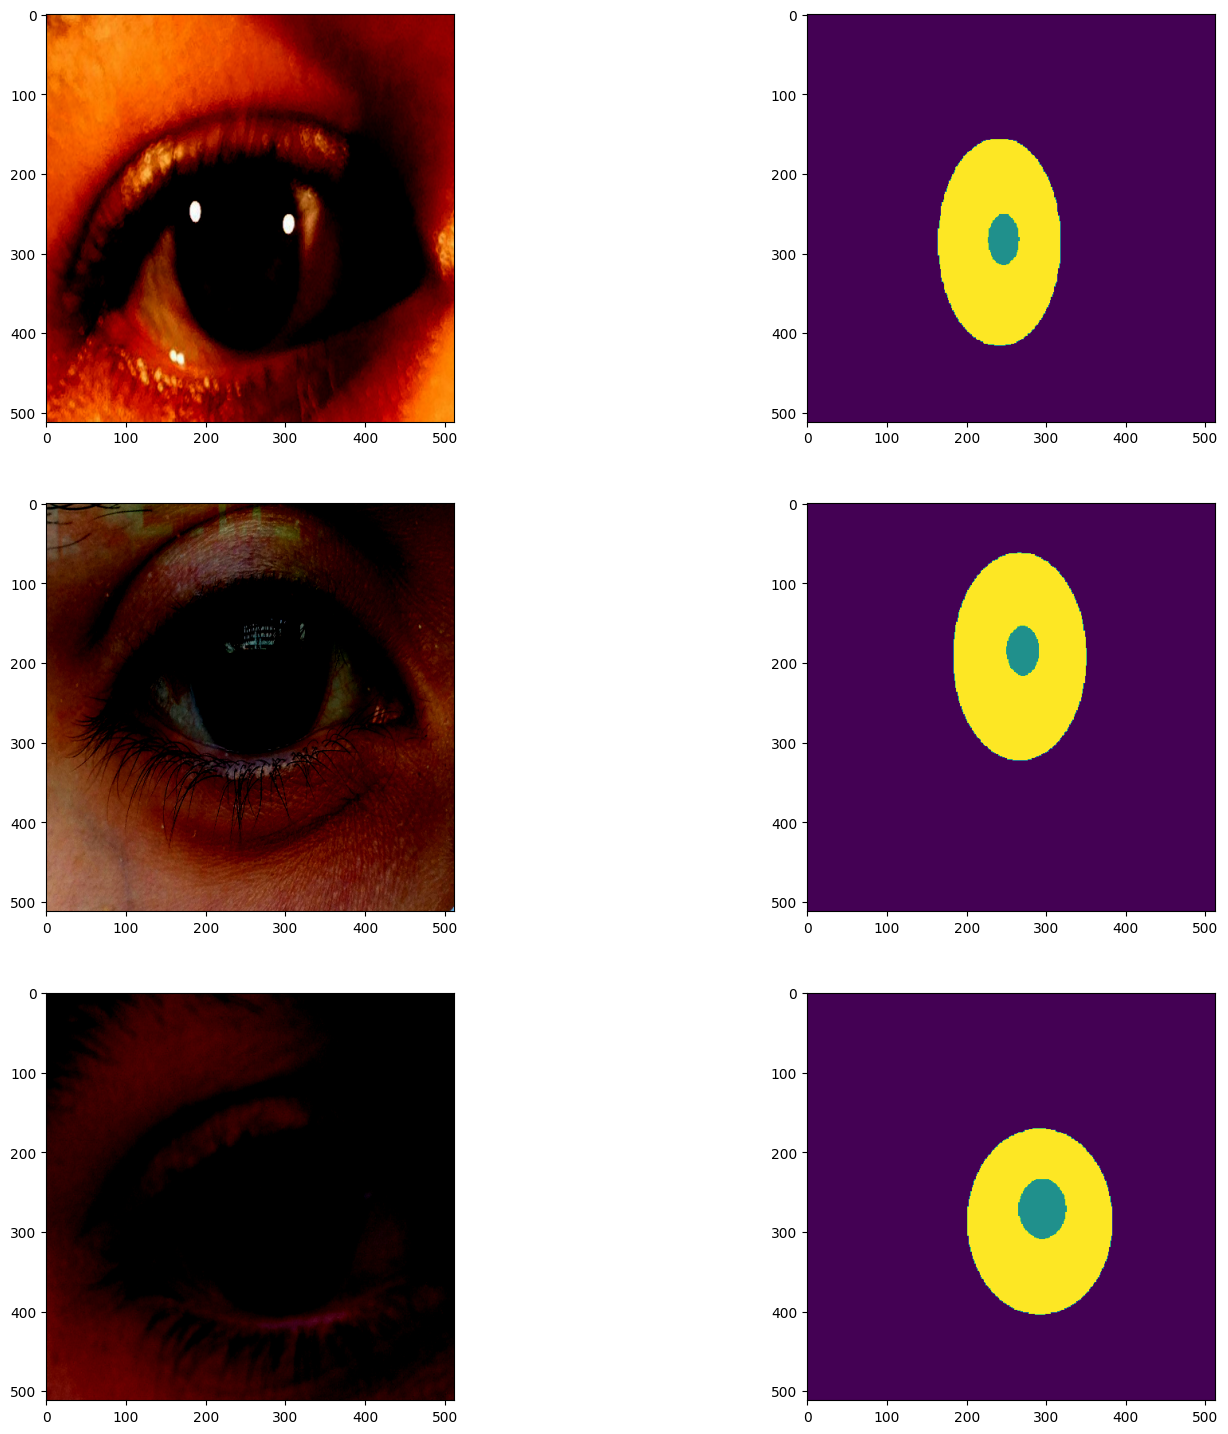

In [13]:
for img,mask in train_batch:
    print(img.shape)
    img1 = np.transpose(img[0,:,:,:],(1,2,0))
    mask1 = np.array(mask[0,:,:])
    img2 = np.transpose(img[1,:,:,:],(1,2,0))
    mask2 = np.array(mask[1,:,:])
    img3 = np.transpose(img[2,:,:,:],(1,2,0))
    mask3 = np.array(mask[2,:,:])
    fig , ax =  plt.subplots(3, 2, figsize=(18, 18))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    break

In [14]:
class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)    

In [15]:
class unet_model(nn.Module):
    def __init__(self,out_channels=23,features=[64, 128, 256, 512]):
        super(unet_model,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

In [16]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
model = unet_model().to(DEVICE)

In [18]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
    encoding_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [19]:
LEARNING_RATE = 1e-4
num_epochs = 10

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [21]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

  0%|          | 0/164 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 5.81 GiB total capacity; 4.31 GiB already allocated; 252.00 MiB free; 4.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF